<div align="right">Student Name: <b>Vishal Beniwal</b><br>Student Number: <b>s3759790</b><br>Subject Code: <b>COSC 2779</b></div>

# Deep Learning Assignment 1
## Head Pose Estimation

<h3> Notebook 1 </h3>

This Notebook will take you through the steps followed to build a model to __predict the tilt__ in the head pose using the dataset given

In [1]:
#Importing the required libraries
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Load & Prepare The Dataset

This section of the notebook shows the steps taken to load and prepare the given data for modeling. The dataset was uploaded into the notebook work environment and unzipped using the following code.

In [2]:
#Unzipping the upload zip folder
import zipfile
with zipfile.ZipFile('modified_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [3]:
raw_data = pd.read_csv('train_data.csv') 

In [4]:
raw_data.head()

,filename,person_id,series,tilt,pan
0,face_790.jpg,5,1,-15,30
1,face_2445.jpg,5,1,0,-75
2,face_2266.jpg,5,2,-15,-60
3,face_2713.jpg,5,2,0,-90
4,face_2016.jpg,5,2,15,-75


Following code iterate through the data folders and read all the image names to create a data frame with their file path and name

In [5]:
from PIL import Image
import glob

image_list = []
for filepath in glob.glob('modified_data/*.jpg', recursive=True):
   
    filename = filepath.split("/")[-1]
    image_list.append((filepath,filename))  
                      
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['filepath','filename'])

In [6]:
data.head()

,filepath,filename
0,modified_data/face_1982.jpg,face_1982.jpg
1,modified_data/face_1905.jpg,face_1905.jpg
2,modified_data/face_396.jpg,face_396.jpg
3,modified_data/face_1648.jpg,face_1648.jpg
4,modified_data/face_854.jpg,face_854.jpg


<h3>Preprocessing the images</h3>

1. Resizing the images to 32x32 for faster computation
2. Converting them to gray color which brings down the channels in the image from three to one

In [7]:
import cv2
import os

for filepath in glob.glob('modified_data/*.jpg', recursive=True):
    
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(gray,(32,32) , interpolation = cv2.INTER_AREA)
    img_resized.view
    cv2.imwrite(os.path.join(filepath), img_resized)

Following code will pick and plot any 4 random images from the datatset for the validation of changes made

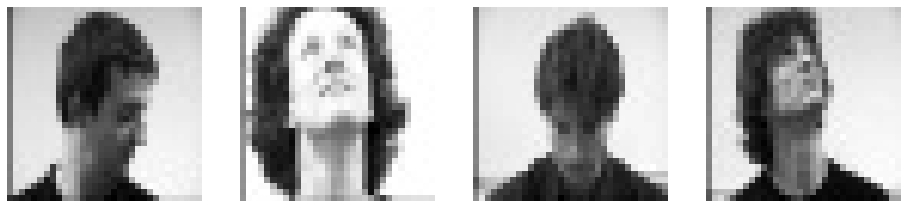

In [8]:
random_index = np.random.choice(100, 4)
rand_data = data.loc[random_index,'filepath']

plt.figure(figsize=(16,4))
for i, filename in enumerate(rand_data):
    im = np.asarray(Image.open(filename))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
    
plt.show()

In [9]:
train_data = pd.merge(raw_data,data, on='filename')

<h3> Data Exploration </h3>

In [10]:
train_data.head()

,filename,person_id,series,tilt,pan,filepath
0,face_790.jpg,5,1,-15,30,modified_data/face_790.jpg
1,face_2445.jpg,5,1,0,-75,modified_data/face_2445.jpg
2,face_2266.jpg,5,2,-15,-60,modified_data/face_2266.jpg
3,face_2713.jpg,5,2,0,-90,modified_data/face_2713.jpg
4,face_2016.jpg,5,2,15,-75,modified_data/face_2016.jpg


In [11]:
train_data.shape

(2325, 6)

In [12]:
train_data['person_id'].unique()

array([ 5,  4,  3, 10, 11,  8,  6,  7,  9, 14, 13, 12, 15])

In [13]:
train_data['series'].unique()

array([1, 2])

In [14]:
train_data['tilt'].unique()

array([-15,   0,  15,  30, -60, -30,  90,  60, -90])

In [15]:
train_data['pan'].unique()

array([ 30, -75, -60, -90,  60, -15, -45, -30,  90,  15,  45,   0,  75])

In [16]:
train_data['person_id'].value_counts()

15    186
13    186
11    186
9     186
7     186
5     186
14    186
12    186
10    186
8     186
6     186
4     186
3      93
Name: person_id, dtype: int64

In [17]:
train_data['series'].value_counts()

2    1209
1    1116
Name: series, dtype: int64

In [18]:
train_data['tilt'].value_counts()

 15    325
-15    325
 60    325
-60    325
 30    325
-30    325
 0     325
 90     25
-90     25
Name: tilt, dtype: int64

In [19]:
train_data['tilt'] = train_data['tilt'].astype(str)

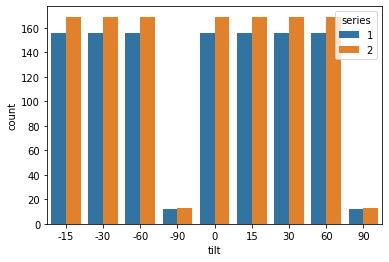

In [20]:
import seaborn as sns
sns.countplot(x='tilt', hue='series', data=train_data)

Creating a subset of the data to classify only the tilt of the head

In [21]:
tilt_train_data = train_data[['filepath','tilt']]

In [22]:
tilt_train_data.head()

,filepath,tilt
0,modified_data/face_790.jpg,-15
1,modified_data/face_2445.jpg,0
2,modified_data/face_2266.jpg,-15
3,modified_data/face_2713.jpg,0
4,modified_data/face_2016.jpg,15


## Data Augmentation

Augmentation has been done for only two class labels which initially had low data samples. The code in this section is going to augment new images and save it to a new directory. The augmented images will be then merged with the original dataset.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

dataAugen = ImageDataGenerator(featurewise_center=True,width_shift_range=0.1,height_shift_range=0.1,zoom_range = 0.2,
                               fill_mode = 'nearest',rescale=1./255, data_format='channels_last')


In [24]:
data_copy = train_data[['filename','filepath','tilt']]
data_copy['tilt'] = data_copy['tilt'].astype(str)
data_copy.head()

,filename,filepath,tilt
0,face_790.jpg,modified_data/face_790.jpg,-15
1,face_2445.jpg,modified_data/face_2445.jpg,0
2,face_2266.jpg,modified_data/face_2266.jpg,-15
3,face_2713.jpg,modified_data/face_2713.jpg,0
4,face_2016.jpg,modified_data/face_2016.jpg,15


In [25]:
data_90 = data_copy[(data_copy['tilt'] == '90')]
data_neg_90 = data_copy[(data_copy['tilt'] == '-90')]

This block of code will store the augmented images with 90 degree tilt in a folder named as "Aug_face90". This block is suppose to run only once at the begining and then, it should be commented

In [26]:
# imglist = []
# imglist = data_90['filepath']
# for filepath in imglist:
    
#     img = load_img(filepath)
#     x = img_to_array(img)
#     x = x.reshape((1,)+ x.shape)
#     i=0
#     for batch in dataAugen.flow(x, batch_size=1, save_to_dir='Aug_face90', save_prefix='newface_', save_format = 'jpg'):
#         i+=1
#         if i>10:
#             break

In [27]:
image_list = []
for filepath in glob.glob('Aug_face90/*.jpg', recursive=True):
   
    filename = filepath.split("/")[-1]
    image_list.append((filepath,'90'))  
                      
# Create a data frame
augdata = pd.DataFrame(data=image_list, columns=['filepath','tilt'])

This block of code will store the augmented images with -90 degree tilt in a folder named as "Aug_faceNeg90". This block is suppose to run only once at the begining and then, it should be commented

In [28]:
# imglist2 = []
# imglist2 = data_neg_90['filepath']
# for filepath in imglist2:
    
#     img = load_img(filepath)
#     x = img_to_array(img)
#     x = x.reshape((1,)+ x.shape)
#     i=0
#     for batch in dataAugen.flow(x, batch_size=1, save_to_dir='Aug_faceNeg90', save_prefix='newface_', save_format = 'jpg'):
#         i+=1
#         if i>10:
#             break

In [29]:
image_list = []
for filepath in glob.glob('Aug_faceNeg90/*.jpg', recursive=True):
   
    filename = filepath.split("/")[-1]
    image_list.append((filepath,'-90'))  
                      
# Create a data frame
augdata2 = pd.DataFrame(data=image_list, columns=['filepath','tilt'])

In [30]:
frames = [tilt_train_data, augdata, augdata2]

# concatenate dataframes
tilt_train_data = pd.concat(frames)

In [31]:
tilt_train_data['tilt'].value_counts()

15     325
-60    325
-15    325
-30    325
0      325
60     325
30     325
90     298
-90    295
Name: tilt, dtype: int64

In [32]:
# import shutil

# shutil.rmtree('newfacepan')

## Training, Validation and Testing Dataset

The following code is using sklearn library to perform hold-out cross validation and split the dataset into 3 subsets.The testing data will be hold out for the purpose of predictions

In [33]:
from sklearn.model_selection import train_test_split

train_data_sample, testing_data = train_test_split(tilt_train_data,test_size = 0.2)
training_data, validation_data = train_test_split(train_data_sample,test_size = 0.2)

In [34]:
training_data.shape

(1835, 2)

In [35]:
validation_data.shape

(459, 2)

In [36]:
testing_data.shape

(574, 2)

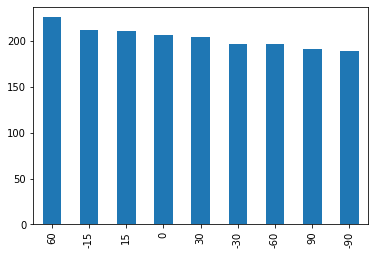

In [37]:
training_data.tilt.value_counts().plot(kind='bar')

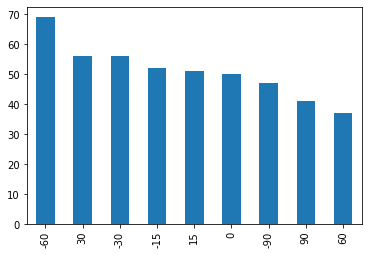

In [38]:
validation_data.tilt.value_counts().plot(kind='bar')

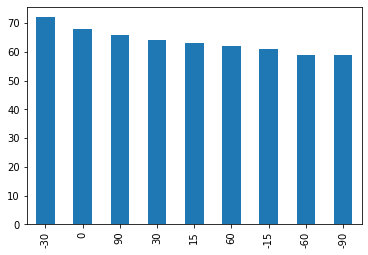

In [39]:
testing_data.tilt.value_counts().plot(kind='bar')

## Functions For Model Evaluation & Plotting Results

The following sections define three functions to improve the code readability and useability in the later section of the notebook:

1. The First function calculates and returns the average accuracy and the loss for a given image stream.
2. The Second function is used to calculate the accuracy and losses of a trained model
3. The Third function is used to plot the results gained after modelling.

In [40]:
def calculate_losses(model_, data_generator_, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    for x,y in data_generator_:
        loss,acc = model_.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    return np.mean(loss_hold), np.mean(acc_hold)

In [41]:
def train_model(model_, num_epoch=100, verbose=1):
    res = []
    for e in range(num_epoch):
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [42]:
def plot_results(res):
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

## Model Training & Evaluation

The next block of code:

1. Define the ImageDataGenerator to stream the data into model from dataframes in a specified batch size.
2. Rescale the images to normalize them
3. Define the batch size

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_data,
    directory='./',
    x_col="filepath",
    y_col="tilt",
    target_size=(32,32),
    shuffle=True,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory='./',
    x_col="filepath",
    y_col="tilt",
    target_size=(32,32),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testing_data,
    directory='./',
    x_col="filepath",
    y_col="tilt",
    target_size=(32, 32),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

Found 1835 validated image filenames belonging to 9 classes.
Found 459 validated image filenames belonging to 9 classes.
Found 574 validated image filenames belonging to 9 classes.


In [44]:
# Defining variables with train and validation sample size for later use
N_train_images = 1835
N_val_images = 459

<h2> Convolution Neural Networks </h2>

__Model1__: Inspired from standard LeNet-5 Model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_28 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
activation_29 (Activation)   (None, 13, 13, 128)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 128)        

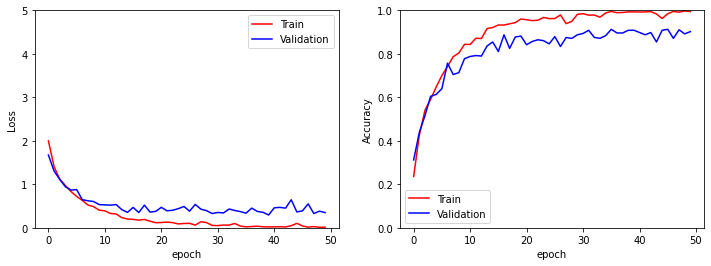

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input,BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

Model1 = Sequential()

# input
Model1.add(Input(shape=(32, 32, 3)))

Model1.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
Model1.add(Conv2D(64, (3, 3)))
Model1.add(Activation('relu'))

Model1.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
Model1.add(Conv2D(128, (3, 3)))
Model1.add(Activation('relu'))

Model1.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
Model1.add(Flatten())
Model1.add(Dense(128))
Model1.add(Activation('relu'))
Model1.add(Dense(128))
Model1.add(Activation('relu'))
Model1.add(Dense(9))
Model1.add(Activation('softmax'))

Model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

Model1.summary()

res = train_model(Model1, num_epoch= 50, verbose=1)

plot_results(res)

__Model1v2__: Network to solve the problem of overfitting by introducing regularization

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_33 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
activation_34 (Activation)   (None, 13, 13, 128)      

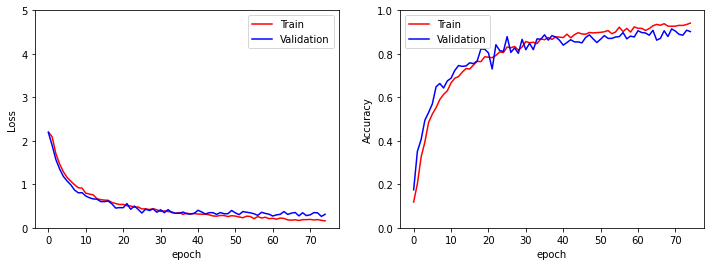

In [53]:
Model1v2 = Sequential()

# input
Model1v2.add(Input(shape=(32, 32, 3)))

Model1v2.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
Model1v2.add(Conv2D(64, (3, 3)))
Model1v2.add(Activation('relu'))
Model1v2.add(MaxPooling2D(pool_size=(2, 2)))
Model1v2.add(Dropout(0.5))

# Conv Layer 2 
Model1v2.add(Conv2D(128, (3, 3)))
Model1v2.add(Activation('relu'))
Model1v2.add(MaxPooling2D(pool_size=(2, 2)))
Model1v2.add(Dropout(0.5))

# MLP
Model1v2.add(Flatten())
Model1v2.add(Dense(128))
Model1v2.add(Activation('relu'))
Model1v2.add(Dense(128))
Model1v2.add(Activation('relu'))
Model1v2.add(Dropout(0.5))
Model1v2.add(Dense(9))
Model1v2.add(Activation('softmax'))

Model1v2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

Model1v2.summary()

res = train_model(Model1v2, num_epoch= 75, verbose=1)

plot_results(res)

__Model2__: To increase the performance of the base model, this network has more depth and width. 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)       

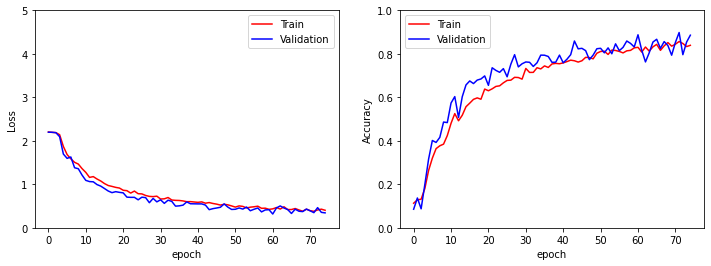

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input,BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

#FINAL MODEL
Model2 = Sequential()

# input
Model2.add(Input(shape=(32, 32, 3)))

Model2.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
Model2.add(Conv2D(64, (3, 3)))
Model2.add(Activation('relu'))
Model2.add(Dropout(0.5))

# Conv Layer 2
Model2.add(Conv2D(64, (3, 3)))
Model2.add(Activation('relu'))
Model2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3
Model2.add(Conv2D(128, (3, 3)))
Model2.add(Activation('relu'))
Model2.add(Dropout(0.5))

# Conv Layer 4
Model2.add(Conv2D(128, (3, 3)))
Model2.add(Activation('relu'))
Model2.add(MaxPooling2D(pool_size=(2, 2)))


# MLP
Model2.add(Flatten())
Model2.add(Dense(128))
Model2.add(Activation('relu'))
Model2.add(Dropout(0.5))
Model2.add(Dense(128))
Model2.add(Activation('relu'))
Model2.add(Dropout(0.5))
Model2.add(Dense(9))
Model2.add(Activation('softmax'))

Model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

Model2.summary()

res = train_model(Model2, num_epoch= 75, verbose=1)

plot_results(res)

## Hyper-Parameter Tuning

Hyper Parameter Tuning process for a deep learning network requires knowledge about different configuration and extensive trial and error until you find a best configuration for your model.

__Model2v2__: Modified version of Model2 with __SGD Optimizer__ while tuning the learning rate

In [56]:
Model2v2 = Sequential()

# input
Model2v2.add(Input(shape=(32, 32, 3)))

Model2v2.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 


# Conv Layer 1
Model2v2.add(Conv2D(64, (3, 3)))
Model2v2.add(Activation('relu'))
Model2v2.add(MaxPooling2D(pool_size=(2, 2)))

Model2v2.add(Conv2D(64, (3, 3)))
Model2v2.add(Activation('relu'))
Model2v2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2
Model2v2.add(Conv2D(128, (3, 3)))
Model2v2.add(Activation('relu'))
Model2v2.add(MaxPooling2D(pool_size=(2, 2)))


# MLP
Model2v2.add(Flatten())
Model2v2.add(Dense(128))
Model2v2.add(Activation('relu'))
Model2v2.add(Dropout(0.5))
Model2v2.add(Dense(9))
Model2v2.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
Model2v2.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=[categorical_accuracy])

Model2v2.summary()

res = train_model(Model2v2, num_epoch= 50, verbose=0)

plot_results(res)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_45 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
activation_46 (Activation)   (None, 13, 13, 128)       0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 128)        

KeyboardInterrupt: 

__Model3v1__: Tuning Dropout Layer

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_21 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_22 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)       

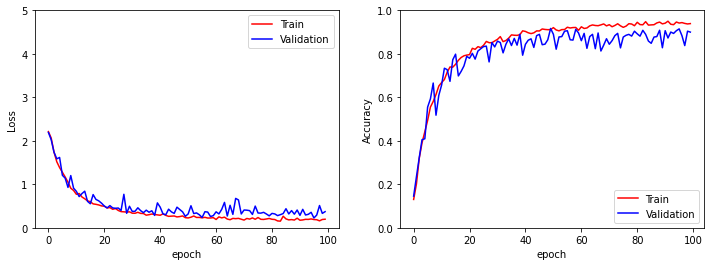

In [51]:
#FINAL MODEL VERSION 2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input,BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

Model3 = Sequential()

# input
Model3.add(Input(shape=(32, 32, 3)))

Model3.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
Model3.add(Conv2D(64, (3, 3)))
Model3.add(Activation('relu'))
Model3.add(Dropout(0.5))

# Conv Layer 2
Model3.add(Conv2D(64, (3, 3)))
Model3.add(Activation('relu'))
Model3.add(MaxPooling2D(pool_size=(2, 2)))
Model3.add(Dropout(0.5))

# Conv Layer 3
Model3.add(Conv2D(128, (3, 3)))
Model3.add(Activation('relu'))
Model3.add(Dropout(0.5))

# Conv Layer 
Model3.add(Conv2D(128, (3, 3)))
Model3.add(Activation('relu'))
Model3.add(MaxPooling2D(pool_size=(2, 2)))
Model3.add(Dropout(0.5))

# MLP
Model3.add(Flatten())
Model3.add(Dense(256))
Model3.add(Activation('relu'))
Model3.add(Dense(256))
Model3.add(Activation('relu'))
Model3.add(Dropout(0.5))
Model3.add(Dense(9))
Model3.add(Activation('softmax'))

Model3.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=[categorical_accuracy])

Model3.summary()

res = train_model(Model3, num_epoch= 100, verbose=1)

plot_results(res)

In [ ]:
# mylist=[0.2,0.3,0.4,0.5]

# for dp in mylist:
    
#     Model3v1 = Sequential()

#     # input
#     Model3v1.add(Input(shape=(32, 32, 3)))

#     Model3v1.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

#     # Conv Layer 1
#     Model3v1.add(Conv2D(64, (3, 3)))
#     Model3v1.add(Activation('relu'))
#     Model3v1.add(Dropout(dp))

#     # Conv Layer 2
#     Model3v1.add(Conv2D(64, (3, 3)))
#     Model3v1.add(Activation('relu'))
#     Model3v1.add(MaxPooling2D(pool_size=(2, 2)))
#     Model3v1.add(Dropout(dp))

#     # Conv Layer 3
#     Model3v1.add(Conv2D(128, (3, 3)))
#     Model3v1.add(Activation('relu'))
#     Model3v1.add(Dropout(dp))

#     # Conv Layer 4
#     Model3v1.add(Conv2D(128, (3, 3)))
#     Model3v1.add(Activation('relu'))
#     Model3v1.add(MaxPooling2D(pool_size=(2, 2)))
#     Model3v1.add(Dropout(dp))

#     # MLP
#     Model3v1.add(Flatten())
#     Model3v1.add(Dense(256))
#     Model3v1.add(Activation('relu'))
#     Model3v1.add(Dense(256))
#     Model3v1.add(Activation('relu'))
#     Model3v1.add(Dropout(0.5))
#     Model3v1.add(Dense(9))
#     Model3v1.add(Activation('softmax'))

#     Model3v1.compile(loss='categorical_crossentropy',optimizer='RMSProp',metrics=[categorical_accuracy])

#     Model3v1.summary()

#     res = train_model(Model3v1, num_epoch= 50, verbose=0)
    
#     print('trained with dropout {}'.format(dp))

#     plot_results(res)

## Performance Metrics Using the Best Performed Model

In [61]:
from sklearn import metrics

from sklearn.metrics import confusion_matrix

predictions = Model3.predict_generator(test_generator,verbose=1)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
cm = confusion_matrix(true_classes, predictedLabels)
print(cm)
mae = metrics.mean_absolute_error(true_classes, predictedLabels)
print(mae)

18/18 [==============================] - 5s 296ms/step
Prediction shape is (574, 9)
              precision    recall  f1-score   support

         -15       0.70      0.89      0.78        61
         -30       0.87      0.74      0.80        72
         -60       0.96      0.86      0.91        59
         -90       1.00      0.97      0.98        59
           0       0.84      0.94      0.89        68
          15       0.91      0.92      0.91        63
          30       0.98      0.91      0.94        64
          60       1.00      1.00      1.00        62
          90       1.00      0.98      0.99        66

    accuracy                           0.91       574
   macro avg       0.92      0.91      0.91       574
weighted avg       0.92      0.91      0.91       574

[[54  2  0  0  5  0  0  0  0]
 [16 53  0  0  3  0  0  0  0]
 [ 2  6 51  0  0  0  0  0  0]
 [ 0  0  2 57  0  0  0  0  0]
 [ 3  0  0  0 64  1  0  0  0]
 [ 0  0  0  0  4 58  1  0  0]
 [ 1  0  0  0  0  5 58  0  0]
 

## Predictions On Test Dataset

In [63]:
testdata = pd.read_csv('test_data.csv')
testdata.head()

,filename,person_id,series
0,face_33.jpg,2,1
1,face_2148.jpg,2,2
2,face_2119.jpg,2,1
3,face_1262.jpg,2,1
4,face_516.jpg,2,2


In [64]:
predict_data = pd.merge(testdata,data, on='filename')

In [65]:
predict_data.head()

,filename,person_id,series,filepath
0,face_33.jpg,2,1,modified_data/face_33.jpg
1,face_2148.jpg,2,2,modified_data/face_2148.jpg
2,face_2119.jpg,2,1,modified_data/face_2119.jpg
3,face_1262.jpg,2,1,modified_data/face_1262.jpg
4,face_516.jpg,2,2,modified_data/face_516.jpg


In [66]:
predict_data.shape

(465, 4)

In [67]:
predict_data = predict_data[['filepath','filename']]

In [68]:
predict_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


In [69]:
predict_generator = predict_datagen.flow_from_dataframe(
    dataframe=predict_data,
    directory='./',
    x_col="filepath",
    y_col="filename",
    target_size=(32, 32),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

Found 465 validated image filenames belonging to 465 classes.


In [70]:
predictions = Model3.predict_generator(predict_generator,verbose=1)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

15/15 [==============================] - 1s 50ms/step
Prediction shape is (465, 9)


In [71]:
predictedLabels

array([8, 7, 4, 5, 0, 7, 7, 6, 6, 7, 2, 7, 6, 6, 0, 4, 7, 6, 7, 7, 1, 7,
       6, 7, 2, 7, 6, 7, 1, 0, 7, 6, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 6, 6,
       4, 6, 0, 7, 2, 7, 7, 6, 7, 6, 5, 0, 1, 7, 6, 7, 7, 0, 6, 7, 7, 1,
       6, 6, 0, 7, 0, 7, 6, 7, 2, 2, 6, 6, 7, 6, 0, 7, 2, 6, 6, 6, 7, 6,
       6, 7, 5, 4, 6, 0, 6, 5, 7, 6, 7, 5, 7, 4, 6, 7, 7, 7, 7, 7, 7, 2,
       0, 0, 7, 6, 7, 7, 7, 1, 0, 6, 6, 4, 7, 2, 7, 6, 7, 7, 6, 7, 7, 6,
       2, 7, 7, 4, 6, 5, 2, 4, 0, 7, 0, 6, 4, 7, 5, 0, 7, 6, 6, 7, 7, 7,
       7, 0, 2, 7, 7, 7, 6, 4, 7, 6, 0, 7, 7, 1, 7, 4, 6, 5, 7, 6, 6, 2,
       7, 5, 7, 6, 7, 4, 7, 7, 0, 7, 0, 7, 4, 1, 2, 2, 5, 5, 0, 5, 3, 5,
       7, 4, 5, 5, 0, 4, 4, 6, 7, 6, 5, 0, 4, 5, 2, 1, 5, 5, 2, 5, 4, 5,
       0, 5, 2, 0, 5, 7, 1, 2, 0, 4, 5, 1, 7, 5, 1, 1, 4, 7, 7, 6, 1, 0,
       2, 1, 5, 0, 6, 0, 7, 4, 7, 0, 5, 1, 2, 0, 1, 7, 0, 1, 4, 5, 2, 1,
       2, 7, 1, 7, 5, 5, 2, 7, 5, 5, 7, 1, 2, 5, 5, 5, 8, 7, 7, 5, 6, 1,
       6, 2, 6, 5, 4, 7, 5, 5, 6, 2, 5, 7, 5, 1, 7,

In [72]:
for n, i in enumerate(predictedLabels):
    if i == 0:
        predictedLabels[n] = -15
    elif i == 1:
        predictedLabels[n] = -30
    elif i == 2:
        predictedLabels[n] = -60
    elif i == 3:
        predictedLabels[n] = -90
    elif i == 4:
        predictedLabels[n] = 0
    elif i == 5:
        predictedLabels[n] = 15
    elif i == 6:
        predictedLabels[n] = 30
    elif i == 7:
        predictedLabels[n] = 60
    else:
        predictedLabels[n] = 90

In [73]:
predictedLabels

array([ 90,  60,   0,  15, -15,  60,  60,  30,  30,  60, -60,  60,  30,
        30, -15,   0,  60,  30,  60,  60, -30,  60,  30,  60, -60,  60,
        30,  60, -30, -15,  60,  30,  60,  60,  60,  60,  60,  30,  60,
        60,  60,  60,  30,  30,   0,  30, -15,  60, -60,  60,  60,  30,
        60,  30,  15, -15, -30,  60,  30,  60,  60, -15,  30,  60,  60,
       -30,  30,  30, -15,  60, -15,  60,  30,  60, -60, -60,  30,  30,
        60,  30, -15,  60, -60,  30,  30,  30,  60,  30,  30,  60,  15,
         0,  30, -15,  30,  15,  60,  30,  60,  15,  60,   0,  30,  60,
        60,  60,  60,  60,  60, -60, -15, -15,  60,  30,  60,  60,  60,
       -30, -15,  30,  30,   0,  60, -60,  60,  30,  60,  60,  30,  60,
        60,  30, -60,  60,  60,   0,  30,  15, -60,   0, -15,  60, -15,
        30,   0,  60,  15, -15,  60,  30,  30,  60,  60,  60,  60, -15,
       -60,  60,  60,  60,  30,   0,  60,  30, -15,  60,  60, -30,  60,
         0,  30,  15,  60,  30,  30, -60,  60,  15,  60,  30,  6

In [74]:
import pandas as pd
df = pd.DataFrame(predictedLabels, columns=["tilt"])
result = pd.concat([predict_data['filename'],df], axis=1, sort=False)

In [75]:
result.head()

,filename,tilt
0,face_33.jpg,90
1,face_2148.jpg,60
2,face_2119.jpg,0
3,face_1262.jpg,15
4,face_516.jpg,-15


In [76]:
result.to_csv('s3759790_predictions.csv', index=False)

In [ ]:
for n, i in enumerate(predictedLabels):
    if i == 0:
        predictedLabels[n] = -15
    elif i == 1:
        predictedLabels[n] = -30
    elif i == 2:
        predictedLabels[n] = -45
    elif i == 3:
        predictedLabels[n] = -60
    elif i == 4:
        predictedLabels[n] = -75
    elif i == 5:
        predictedLabels[n] = -90
    elif i == 6:
        predictedLabels[n] = 0
    elif i == 7:
        predictedLabels[n] = 15
    elif i == 8:
        predictedLabels[n] = 30
    elif i == 9:
        predictedLabels[n] = 45
    elif i == 10:
        predictedLabels[n] = 60
    elif i == 11:
        predictedLabels[n] = 75
    else:
        predictedLabels[n] = 90

In [ ]:
predict_csv = pd.read_csv('s3759790_predictions.csv') 
predict_data = pd.merge(predict_csv,data, on='filename')